# Init

In [1]:
from dstools.dataset import load_house_prices
from dstools.preprocess import TransformBinary, TransformColumn, TransformImputer, TransformOthers, OrdinalEncoder
from dstools.preprocess import Pipeline

import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd

pd.set_option('display.max_columns', 500)

The next cell create a pipeline, where is used to accumulate transformations of dataset.

In [2]:
preproc = []

# Load Dataset

In [3]:
from sklearn.model_selection import train_test_split

train_ini, test = load_house_prices()
train = train_ini.copy()

X_train, X_test, y_train, y_test = train_test_split(
    train.drop(columns='SalePrice'),train['SalePrice'],
    train_size=0.75, test_size=0.25
)

X_train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
338,20,RL,91.0,14145,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NWAmes,Norm,Norm,1Fam,1Story,7,7,1984,1998,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,Gd,TA,Mn,ALQ,213,Unf,0,995,1208,GasA,Ex,Y,SBrkr,1621,0,0,1621,1,0,2,0,3,1,Gd,8,Typ,0,NaN,Attchd,1984.0,RFn,2,440,TA,TA,Y,108,45,0,0,0,0,NaN,NaN,Shed,400,5,2006,WD,Normal
1067,60,RL,80.0,9760,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,NAmes,Norm,Norm,1Fam,2Story,6,6,1964,1964,Gable,CompShg,HdBoard,HdBoard,BrkFace,360.0,TA,TA,CBlock,TA,TA,Gd,GLQ,674,LwQ,106,0,780,GasA,TA,Y,SBrkr,798,813,0,1611,1,0,1,1,4,1,TA,7,Typ,0,NaN,Attchd,1964.0,RFn,2,442,TA,TA,Y,328,128,0,0,189,0,NaN,NaN,NaN,0,6,2008,WD,Normal
1443,30,RL,NaN,8854,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Unf,6,6,1916,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,Grav,Fa,N,FuseF,952,0,0,952,0,0,1,0,2,1,Fa,4,Typ,1,Gd,Detchd,1916.0,Unf,1,192,Fa,Po,P,0,98,0,0,40,0,NaN,NaN,NaN,0,5,2009,WD,Normal
939,70,RL,NaN,24090,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,2Story,7,7,1940,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Unf,0,Unf,0,1032,1032,GasA,Ex,Y,SBrkr,1207,1196,0,2403,0,0,2,0,4,1,TA,10,Typ,2,TA,Attchd,1940.0,Unf,1,349,TA,TA,Y,56,0,318,0,0,0,NaN,NaN,NaN,0,6,2010,COD,Normal
923,120,RL,50.0,8012,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,TwnhsE,1Story,6,5,1993,1994,Gable,CompShg,Plywood,Plywood,None,0.0,Gd,TA,PConc,Gd,TA,No,LwQ,165,GLQ,841,598,1604,GasA,Ex,Y,SBrkr,1617,0,0,1617,1,0,2,0,2,1,Gd,5,Typ,1,Fa,Attchd,1993.0,RFn,2,533,TA,TA,Y,0,69,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal


In [4]:
X_train.shape

(1095, 79)

In [5]:
X_test.shape

(365, 79)

# Analysis

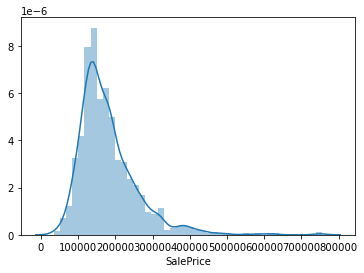

In [6]:
sns.distplot(y_train)

The target column no have a simetric distribution, normaly, it slow down the perfomance.

But this column have only positive values and possibly outliers, this a optmal cenary to use a logaritmic tranform, because this transformation "push" the distribution to the right.

In [7]:
y_train = np.log1p(y_train)

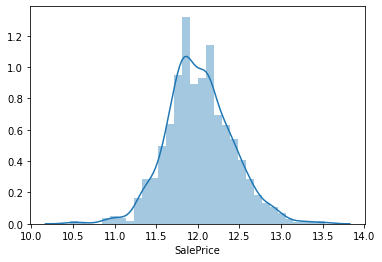

In [8]:
sns.distplot(y_train)

Now we go add function to a list os transformations.

Will be separate the columns by type to facility the analysis

The only non-ordinal columns, this columns will stay separate the rest of the dataset, in the final model we test this columns.

## NaN Values

Will be input non observed data for some columns

In [9]:
aux_nan = X_train.isna().mean().sort_values(ascending = False)
aux_nan = aux_nan[aux_nan > 0]
aux_nan

PoolQC          0.993607
MiscFeature     0.962557
Alley           0.939726
Fence           0.798174
FireplaceQu     0.467580
LotFrontage     0.183562
GarageCond      0.062100
GarageType      0.062100
GarageYrBlt     0.062100
GarageFinish    0.062100
GarageQual      0.062100
BsmtExposure    0.028311
BsmtFinType2    0.028311
BsmtFinType1    0.027397
BsmtCond        0.027397
BsmtQual        0.027397
MasVnrArea      0.004566
MasVnrType      0.004566
Electrical      0.000913
dtype: float64

In [10]:
def mode(x):
    return stats.mode(x).mode[0]

In [11]:
nan_impute = {
    'LotFrontage': ('Neighborhood', np.mean),
    'MasVnrArea': ('Neighborhood', np.mean),
    'Functional': 'Typ',
    'Electrical': 'SBrkr',
    'KitchenQual': 'TA',
    'MSZoning': ('MSSubClass', mode)
    # or MSZoning': ('MSSubClass', lambda x: stats.mode(x).mode[0])
}

In [12]:
t_input = TransformImputer(nan_impute, auto_input = True, not_input = ['SalePrice'])
t_input.fit(X_train)

TransformImputer(auto_input=True,
                 mapping={'1stFlrSF': <function amin at 0x7f0f8eda2a60>,
                          '2ndFlrSF': <function amin at 0x7f0f8eda2a60>,
                          '3SsnPorch': <function amin at 0x7f0f8eda2a60>,
                          'BedroomAbvGr': <function amin at 0x7f0f8eda2a60>,
                          'BsmtFinSF1': <function amin at 0x7f0f8eda2a60>,
                          'BsmtFinSF2': <function amin at 0x7f0f8eda2a60>,
                          'BsmtFullBath': <function amin at 0x7f0f8eda2a60>,
                          '...
                          'LowQualFinSF': <function amin at 0x7f0f8eda2a60>,
                          'MSSubClass': <function amin at 0x7f0f8eda2a60>,
                          'MSZoning': ('MSSubClass',
                                       <function mode at 0x7f0f7a4f8af0>),
                          'MasVnrArea': ('Neighborhood',
                                         <function mean at 0x7f0f8eda4670>

In [13]:
preproc.append(t_input)

In [14]:
X_train = t_input.transform(X_train)

In [15]:
aux_nan = X_train.isna().mean().sort_values(ascending = False)
aux_nan = aux_nan[aux_nan > 0]
aux_nan

PoolQC          0.993607
MiscFeature     0.962557
Alley           0.939726
Fence           0.798174
FireplaceQu     0.467580
GarageFinish    0.062100
GarageQual      0.062100
GarageCond      0.062100
GarageType      0.062100
BsmtFinType2    0.028311
BsmtExposure    0.028311
BsmtQual        0.027397
BsmtCond        0.027397
BsmtFinType1    0.027397
MasVnrType      0.004566
dtype: float64

## Ordinal columns

For ordinal columns will be transform to numeric colmun.

In [16]:
ordinal_cols = {
    'Street':['Grvl','Pave'],
    'LotShape':['Reg','IR1','IR2','IR3'],
    'Utilities':['AllPub','NoSewr','NoSeWa','ELO','NAN'],
    'LandSlope':['Gtl','Mod','Sev'],
    'BldgType':['1Fam','2fmCon','Duplex','Twnhs','TwnhsE'],
    'ExterQual':['Ex','Gd','TA','Fa','Po'],
    'ExterCond':['Ex','Gd','TA','Fa','Po'],
    'BsmtQual':['Ex','Gd','TA','Fa','Po','NAN'],
    'BsmtCond':['Ex','Gd','TA','Fa','Po','NAN'],
    'BsmtExposure':['Gd','Av','Mn','No','NAN'],
    'BsmtFinType1':['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NAN'],
    'BsmtFinType2':['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NAN'],
    'HeatingQC':['Ex','Gd','TA','Fa','Po'],
    'CentralAir':['N','Y'],
    'KitchenQual':['Ex','Gd','TA','Fa','Po','NAN'],
    'FireplaceQu':['Ex','Gd','TA','Fa','Po','NAN'],
    'GarageFinish':['Fin','RFn','Unf','NAN'],
    'GarageQual':['Ex','Gd','TA','Fa','Po','NAN'],
    'GarageCond':['Ex','Gd','TA','Fa','Po','NAN'],
    'PavedDrive':['Y','P','N'],
    'PoolQC':['Ex','Gd','TA','Fa','NAN'],
    'Fence':['GdPrv','MnPrv','GdWo','MnWw','NAN'],
}

In [17]:
tord = OrdinalEncoder(ordinal_cols)
preproc.append(tord)

In [18]:
X_train = tord.transform(X_train)

In [19]:
X_train[ordinal_cols.keys()].head(5)

,Street,LotShape,Utilities,LandSlope,BldgType,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
338,1,0,0,0,0,1,2,1,2,2,1,5,0,1,1,5,1,2,2,0,4,4
1067,1,0,0,1,0,2,2,2,2,0,0,4,2,1,2,5,1,2,2,0,4,4
1443,1,0,0,0,0,2,2,2,2,3,5,5,3,0,3,1,2,3,4,1,4,4
939,1,0,0,0,0,2,1,2,2,2,5,5,0,1,2,2,2,2,2,0,4,4
923,1,0,0,0,4,1,2,1,2,3,4,0,0,1,1,3,1,2,2,0,4,4


In [20]:
aux_nan = X_train.isna().mean().sort_values(ascending = False)
aux_nan = aux_nan[aux_nan > 0]
aux_nan

MiscFeature    0.962557
Alley          0.939726
GarageType     0.062100
MasVnrType     0.004566
dtype: float64

## Nominal columns

In [21]:
X_train.select_dtypes(np.object).head(5)

,MSZoning,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,Electrical,Functional,GarageType,MiscFeature,SaleType,SaleCondition
338,RL,NaN,Lvl,Corner,NWAmes,Norm,Norm,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,CBlock,GasA,SBrkr,Typ,Attchd,Shed,WD,Normal
1067,RL,NaN,Lvl,Inside,NAmes,Norm,Norm,2Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,CBlock,GasA,SBrkr,Typ,Attchd,NaN,WD,Normal
1443,RL,NaN,Lvl,Inside,BrkSide,Norm,Norm,1.5Unf,Gable,CompShg,Wd Sdng,Wd Sdng,None,BrkTil,Grav,FuseF,Typ,Detchd,NaN,WD,Normal
939,RL,NaN,Lvl,Inside,ClearCr,Norm,Norm,2Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,SBrkr,Typ,Attchd,NaN,COD,Normal
923,RL,NaN,Lvl,Inside,SawyerW,Norm,Norm,1Story,Gable,CompShg,Plywood,Plywood,None,PConc,GasA,SBrkr,Typ,Attchd,NaN,WD,Normal


In [22]:
t_others = TransformOthers(threshold=0.1)
t_others.fit(X_train)
preproc.append(t_others)

In [23]:
t_others.relevant_values_

{'MSZoning': ['RL', 'RM'],
 'Alley': [nan],
 'LandContour': ['Lvl'],
 'LotConfig': ['Inside', 'Corner'],
 'Neighborhood': ['NAmes'],
 'Condition1': ['Norm'],
 'Condition2': ['Norm'],
 'HouseStyle': ['1Story', '2Story', '1.5Fin'],
 'RoofStyle': ['Gable', 'Hip'],
 'RoofMatl': ['CompShg'],
 'Exterior1st': ['VinylSd', 'HdBoard', 'MetalSd', 'Wd Sdng'],
 'Exterior2nd': ['VinylSd', 'HdBoard', 'MetalSd', 'Wd Sdng'],
 'MasVnrType': ['None', 'BrkFace'],
 'Foundation': ['PConc', 'CBlock'],
 'Heating': ['GasA'],
 'Electrical': ['SBrkr'],
 'Functional': ['Typ'],
 'GarageType': ['Attchd', 'Detchd'],
 'MiscFeature': [nan],
 'SaleType': ['WD'],
 'SaleCondition': ['Normal']}

In [24]:
X_train = t_others.transform(X_train)

In [25]:
X_train["MiscFeature"].value_counts(normalize=True, dropna=False)

NaN       0.962557
Others    0.037443
Name: MiscFeature, dtype: float64

## Numerical columns

Create new columns

In [26]:
new_cols = {
    'TotalBath': 'X["BsmtFullBath"] + 0.5*X["BsmtHalfBath"] + X["FullBath"] + 0.5*X["HalfBath"]',
    'TotalSqrFootage': 'X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["1stFlrSF"] + X["2ndFlrSF"]',
    'TotalPorch': 'X["OpenPorchSF"] + X["3SsnPorch"] + X["EnclosedPorch"] + X["ScreenPorch"] + X["WoodDeckSF"]'
}

t_newcol = TransformColumn(new_cols)
t_newcol.fit(X_train)
preproc.append(t_newcol)

In [27]:
X_train = t_newcol.transform(X_train)

In [28]:
X_train[['TotalBath', 'TotalSqrFootage', 'TotalPorch']].describe()

,TotalBath,TotalSqrFootage,TotalPorch
count,1095.000000,1095.000000,1095.000000
mean,2.201826,1990.687671,181.589041
std,0.785725,790.315014,156.360699
min,1.000000,672.000000,0.000000
25%,2.000000,1484.500000,45.000000
50%,2.000000,1834.000000,164.000000
75%,2.500000,2366.000000,265.500000
max,6.000000,11286.000000,1027.000000


Now the objective is a discover the colums wich interessing to transform in binary columns.

This coluns problably will be bad features to model, so will binarize this columns.

In [29]:
t_bin = TransformBinary()
X_train = t_bin.fit_transform(X_train)
preproc.append(t_bin)

In [30]:
t_bin.cols_bin_

['bin_MSZoning_RL',
 'bin_LandContour_Lvl',
 'bin_LotConfig_Inside',
 'bin_Neighborhood_Others',
 'bin_Condition1_Norm',
 'bin_HouseStyle_1Story',
 'bin_RoofStyle_Gable',
 'bin_MasVnrType_None',
 'bin_Electrical_SBrkr',
 'bin_Functional_Typ',
 'bin_GarageType_Attchd',
 'bin_SaleType_WD',
 'bin_SaleCondition_Normal']

In [31]:
t_bin.cols_drop_

['Alley', 'Condition2', 'RoofMatl', 'Heating', 'MiscFeature']

In [32]:
X_train.head(5)

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,BldgType,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,TotalBath,TotalSqrFootage,TotalPorch,bin_MSZoning_RL,bin_LandContour_Lvl,bin_LotConfig_Inside,bin_Neighborhood_Others,bin_Condition1_Norm,bin_HouseStyle_1Story,bin_RoofStyle_Gable,bin_MasVnrType_None,bin_Electrical_SBrkr,bin_Functional_Typ,bin_GarageType_Attchd,bin_SaleType_WD,bin_SaleCondition_Normal
338,20,91.000000,14145,1,0,0,0,0,7,7,1984,1998,Wd Sdng,Wd Sdng,0.0,1,2,CBlock,1,2,2,1,213,5,0,995,1208,0,1,1621,0,0,1621,1,0,2,0,3,1,1,8,0,5,1984.0,1,2,440,2,2,0,108,45,0,0,0,0,4,4,400,5,2006,3.0,1834,153,1,1,0,1,1,1,1,1,1,1,1,1,1
1067,60,80.000000,9760,1,0,0,1,0,6,6,1964,1964,HdBoard,HdBoard,360.0,2,2,CBlock,2,2,0,0,674,4,106,0,780,2,1,798,813,0,1611,1,0,1,1,4,1,2,7,0,5,1964.0,1,2,442,2,2,0,328,128,0,0,189,0,4,4,0,6,2008,2.5,2391,645,1,1,1,0,1,0,1,0,1,1,1,1,1
1443,30,54.583333,8854,1,0,0,0,0,6,6,1916,1950,Wd Sdng,Wd Sdng,0.0,2,2,Others,2,2,3,5,0,5,0,952,952,3,0,952,0,0,952,0,0,1,0,2,1,3,4,1,1,1916.0,2,1,192,3,4,1,0,98,0,0,40,0,4,4,0,5,2009,1.0,952,138,1,1,1,1,1,0,1,1,0,1,0,1,1
939,70,87.000000,24090,1,0,0,0,0,7,7,1940,1950,MetalSd,MetalSd,0.0,2,1,CBlock,2,2,2,5,0,5,0,1032,1032,0,1,1207,1196,0,2403,0,0,2,0,4,1,2,10,2,2,1940.0,2,1,349,2,2,0,56,0,318,0,0,0,4,4,0,6,2010,2.0,2403,374,1,1,1,1,1,0,1,1,1,1,1,0,1
923,120,50.000000,8012,1,0,0,0,4,6,5,1993,1994,Others,Others,0.0,1,2,PConc,1,2,3,4,165,0,841,598,1604,0,1,1617,0,0,1617,1,0,2,0,2,1,1,5,1,3,1993.0,1,2,533,2,2,0,0,69,0,0,0,0,4,4,0,7,2008,3.0,2623,69,1,1,1,1,1,1,1,1,1,1,1,1,1


The first objective is to research the columns that can cause mulcholinearity problem.

This columns will be separated to test in the final model.

# Final transformation

In [33]:
pipe = Pipeline(preproc)
pipe

Pipeline(pre_process=[TransformImputer(auto_input=True,
                                       mapping={'1stFlrSF': <function amin at 0x7f0f8eda2a60>,
                                                '2ndFlrSF': <function amin at 0x7f0f8eda2a60>,
                                                '3SsnPorch': <function amin at 0x7f0f8eda2a60>,
                                                'BedroomAbvGr': <function amin at 0x7f0f8eda2a60>,
                                                'BsmtFinSF1': <function amin at 0x7f0f8eda2a60>,
                                                'BsmtFinSF2': <function amin at 0x7f0f8eda2a60>,
                                                'BsmtFullBath': <function a...
                      TransformColumn(mapping={'TotalBath': 'X["BsmtFullBath"] '
                                                            '+ '
                                                            '0.5*X["BsmtHalfBath"] '
                                                       

In [34]:
%%timeit
test_ = pipe.transform(X_test)

239 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
X_train = pd.get_dummies(X_train)
X_train.head(5)

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,BldgType,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,TotalBath,TotalSqrFootage,TotalPorch,bin_MSZoning_RL,bin_LandContour_Lvl,bin_LotConfig_Inside,bin_Neighborhood_Others,bin_Condition1_Norm,bin_HouseStyle_1Story,bin_RoofStyle_Gable,bin_MasVnrType_None,bin_Electrical_SBrkr,bin_Functional_Typ,bin_GarageType_Attchd,bin_SaleType_WD,bin_SaleCondition_Normal,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Others,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Others,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Foundation_CBlock,Foundation_Others,Foundation_PConc
338,20,91.000000,14145,1,0,0,0,0,7,7,1984,1998,0.0,1,2,1,2,2,1,213,5,0,995,1208,0,1,1621,0,0,1621,1,0,2,0,3,1,1,8,0,5,1984.0,1,2,440,2,2,0,108,45,0,0,0,0,4,4,400,5,2006,3.0,1834,153,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0
1067,60,80.000000,9760,1,0,0,1,0,6,6,1964,1964,360.0,2,2,2,2,0,0,674,4,106,0,780,2,1,798,813,0,1611,1,0,1,1,4,1,2,7,0,5,1964.0,1,2,442,2,2,0,328,128,0,0,189,0,4,4,0,6,2008,2.5,2391,645,1,1,1,0,1,0,1,0,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0
1443,30,54.583333,8854,1,0,0,0,0,6,6,1916,1950,0.0,2,2,2,2,3,5,0,5,0,952,952,3,0,952,0,0,952,0,0,1,0,2,1,3,4,1,1,1916.0,2,1,192,3,4,1,0,98,0,0,40,0,4,4,0,5,2009,1.0,952,138,1,1,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0
939,70,87.000000,24090,1,0,0,0,0,7,7,1940,1950,0.0,2,1,2,2,2,5,0,5,0,1032,1032,0,1,1207,1196,0,2403,0,0,2,0,4,1,2,10,2,2,1940.0,2,1,349,2,2,0,56,0,318,0,0,0,4,4,0,6,2010,2.0,2403,374,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0
923,120,50.000000,8012,1,0,0,0,4,6,5,1993,1994,0.0,1,2,1,2,3,4,165,0,841,598,1604,0,1,1617,0,0,1617,1,0,2,0,2,1,1,5,1,3,1993.0,1,2,533,2,2,0,0,69,0,0,0,0,4,4,0,7,2008,3.0,2623,69,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1


In [36]:
pipe.append(pd.get_dummies)

Pipeline(pre_process=[TransformImputer(auto_input=True,
                                       mapping={'1stFlrSF': <function amin at 0x7f0f8eda2a60>,
                                                '2ndFlrSF': <function amin at 0x7f0f8eda2a60>,
                                                '3SsnPorch': <function amin at 0x7f0f8eda2a60>,
                                                'BedroomAbvGr': <function amin at 0x7f0f8eda2a60>,
                                                'BsmtFinSF1': <function amin at 0x7f0f8eda2a60>,
                                                'BsmtFinSF2': <function amin at 0x7f0f8eda2a60>,
                                                'BsmtFullBath': <function a...
                                                            '0.5*X["BsmtHalfBath"] '
                                                            '+ X["FullBath"] + '
                                                            '0.5*X["HalfBath"]',
                                       

# Model

In [37]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [38]:
def rmse(y_true, y_pred):       
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [39]:
xg = xgb.XGBRegressor(objective='reg:squarederror')

In [40]:
xg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
rmse(np.expm1(xg.predict(X_train)), np.expm1(y_train))

947.7288637444095

In [42]:
pipe.append(xg, "model").append(np.expm1, "pos_process")

Pipeline(model=XGBRegressor(base_score=0.5, booster='gbtree',
                            colsample_bylevel=1, colsample_bynode=1,
                            colsample_bytree=1, gamma=0, gpu_id=-1,
                            importance_type='gain', interaction_constraints='',
                            learning_rate=0.300000012, max_delta_step=0,
                            max_depth=6, min_child_weight=1, missing=nan,
                            monotone_constraints='()', n_estimators=100,
                            n_jobs=0, num_parallel_tree=1, random...
                                                            '0.5*X["BsmtHalfBath"] '
                                                            '+ X["FullBath"] + '
                                                            '0.5*X["HalfBath"]',
                                               'TotalPorch': 'X["OpenPorchSF"] '
                                                             '+ X["3SsnPorch"] '
                       

In [43]:
pipe.save("pipeline.pkl")

In [44]:
X_test_t, y_pred = pipe(X_test)

In [45]:
rmse(y_pred, y_test)

24488.442973880658

In [46]:
X_test_t.head(5)

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,BldgType,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,TotalBath,TotalSqrFootage,TotalPorch,bin_MSZoning_RL,bin_LandContour_Lvl,bin_LotConfig_Inside,bin_Neighborhood_Others,bin_Condition1_Norm,bin_HouseStyle_1Story,bin_RoofStyle_Gable,bin_MasVnrType_None,bin_Electrical_SBrkr,bin_Functional_Typ,bin_GarageType_Attchd,bin_SaleType_WD,bin_SaleCondition_Normal,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Others,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Others,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Foundation_CBlock,Foundation_Others,Foundation_PConc
873,40,60.000000,12144,1,0,0,0,0,5,7,1949,1950,0.0,1,2,2,2,3,3,375,5,0,457,832,1,1,1036,0,232,1268,0,0,1,0,3,1,2,6,1,1,1949.0,2,1,288,2,2,0,0,28,0,0,0,0,4,4,0,9,2009,1.0,1411,28,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0
719,20,69.000000,9920,1,1,0,0,0,5,6,1969,1969,0.0,2,2,1,2,0,1,523,5,0,448,971,2,1,971,0,0,971,0,0,1,1,3,1,2,5,1,4,1969.0,2,1,300,2,2,0,0,0,0,0,0,0,4,4,0,5,2006,1.5,1494,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0
1409,60,46.000000,20544,1,1,0,0,0,7,6,1986,1991,123.0,2,1,1,2,3,5,0,5,0,791,791,1,1,1236,857,0,2093,0,0,2,1,3,1,2,7,1,2,1986.0,0,2,542,2,2,0,364,63,0,0,0,0,4,1,0,11,2008,2.5,2093,427,1,1,0,1,1,0,1,0,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0
518,60,71.861111,9531,1,1,0,0,0,6,5,1998,1998,0.0,2,2,1,2,2,0,706,5,0,88,794,0,1,882,914,0,1796,1,0,2,1,3,1,2,7,0,5,1998.0,1,2,546,2,2,0,0,36,0,0,0,0,4,1,0,5,2007,3.5,2502,36,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1
867,20,85.000000,6970,1,0,0,0,0,4,5,1961,1961,0.0,2,2,2,2,3,1,932,5,0,108,1040,2,1,1120,0,0,1120,1,0,1,1,3,1,3,5,0,5,1961.0,1,2,544,2,2,0,168,0,0,0,0,0,4,4,400,5,2007,2.5,2052,168,1,1,0,1,0,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0
